Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 57s 249ms/step - dice_coefficient: 0.0284 - loss: 0.9022 - val_dice_coefficient: 0.0294 - val_loss: 0.7418 - learning_rate: 0.0010
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - dice_coefficient: 0.0309 - loss: 0.6730 - val_dice_coefficient: 0.0306 - val_loss: 0.6542 - learning_rate: 0.0010
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 221ms/step - dice_coefficient: 0.0568 - loss: 0.5869 - val_dice_coefficient: 0.0652 - val_loss: 0.5810 - learning_rate: 0.0010
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - dice_coefficient: 0.1168 - loss: 0.5150 - val_dice_coefficient: 0.0618 - val_loss: 0.5616 - learning_rate: 0.0010
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 32s 229ms/step - dice_coefficient: 0.2007 - loss: 0.4466 - val_dice_coefficient: 0.1932 - val_loss: 0.4392 - learning_rate: 0.0010
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 221ms/step - dice_coefficient: 0.3781 - loss: 0.3413 - val_dice_coefficient: 0.1795 - val_loss: 0.6072 - le

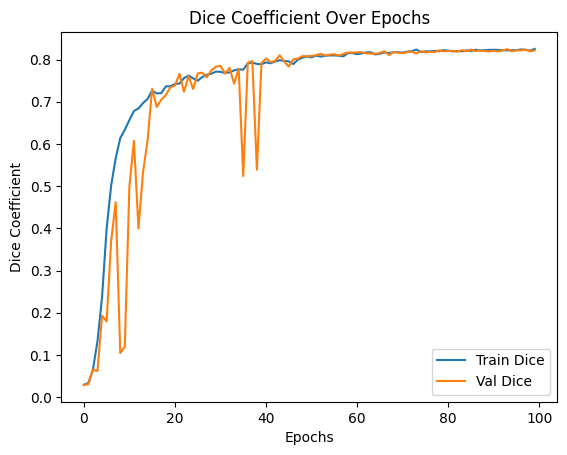

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import cv2
import albumentations as A

# Dice coefficient function
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Combined Dice and Binary Cross Entropy loss
def dice_bce_loss(y_true, y_pred):
    dice_loss = 1 - dice_coefficient(y_true, y_pred)
    bce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return 0.5 * dice_loss + 0.5 * bce_loss  # Balance both losses

# Data augmentation using Albumentations
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.ElasticTransform(p=0.2),
    A.GaussianBlur(p=0.1)
])

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, img_size, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.indices = np.arange(len(self.image_paths))

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images, batch_masks = [], []

        for i in indices:
            img = cv2.imread(self.image_paths[i])
            mask = cv2.imread(self.mask_paths[i], cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size) / 255.0
            mask = cv2.resize(mask, self.img_size) / 255.0

            if self.augment:
                augmented = augmentation(image=img, mask=mask)
                img, mask = augmented["image"], augmented["mask"]

            batch_images.append(img)
            batch_masks.append(np.expand_dims(mask, axis=-1))

        return np.array(batch_images), np.array(batch_masks)

# Improved U-Net Model
def create_model():
    inputs = tf.keras.Input(shape=(128, 128, 3))

    def conv_block(x, filters):
        x = layers.Conv2D(filters, (3, 3), padding='same', activation=None)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, (3, 3), padding='same', activation=None)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x

    def encoder_block(x, filters):
        x = conv_block(x, filters)
        p = layers.MaxPooling2D((2, 2))(x)
        p = layers.Dropout(0.1)(p)
        return x, p

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    # Encoder
    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    # Bottleneck
    b = conv_block(p4, 256)

    # Decoder
    d1 = decoder_block(b, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=dice_bce_loss, metrics=[dice_coefficient])
    return model

# Paths to dataset
image_dir = '/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames'
mask_dir = '/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks'

# Load file paths
image_paths = sorted([os.path.join(image_dir, img) for img in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, mask) for mask in os.listdir(mask_dir)])

# Split into training & validation sets
train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Create data generators
train_gen = DataGenerator(train_images, train_masks, batch_size=8, img_size=(128, 128), augment=True)
val_gen = DataGenerator(val_images, val_masks, batch_size=8, img_size=(128, 128), augment=False)

# Create model
model = create_model()

# Callbacks for better training
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")  # Changed from .h5 to .keras
]


# Train the model
history = model.fit(train_gen, validation_data=val_gen, epochs=100, callbacks=callbacks)

# Plot training results
import matplotlib.pyplot as plt
plt.plot(history.history['dice_coefficient'], label='Train Dice')
plt.plot(history.history['val_dice_coefficient'], label='Val Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.title('Dice Coefficient Over Epochs')
plt.show()


# **Testing**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


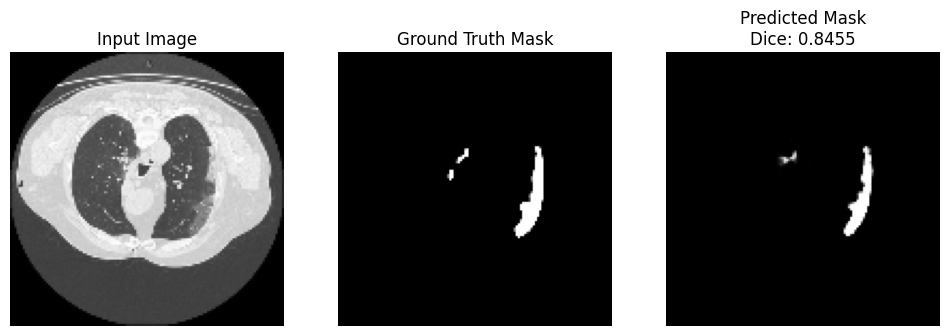

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Function to calculate Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Load test data (adjust as per your dataset structure)
test_images, test_masks = next(iter(train_gen))  # Get a batch of test images and masks
predicted_masks = model.predict(test_images)    # Generate predicted masks

# Choose an index to visualize (e.g., the first image in the batch)
index = 3
input_image = test_images[index]
ground_truth_mask = test_masks[index]
predicted_mask = predicted_masks[index]

# Calculate Dice score for the chosen image
dice_score = dice_coefficient(ground_truth_mask, predicted_mask)

# Plot the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(input_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(ground_truth_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Predicted Mask\nDice: {dice_score.numpy():.4f}")
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')

plt.show()


Loaded segmentation_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


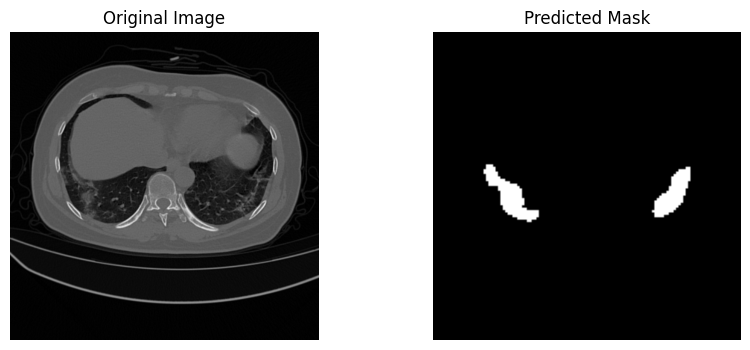

In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Custom Dice Coefficient function
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Load models
model_path_1 = "/kaggle/working/segmentation_model.h5"
model_path_2 = "/kaggle/working/best_model.keras"

if os.path.exists(model_path_1):
    model = load_model(model_path_1, custom_objects={'dice_coefficient': dice_coefficient}, compile=False)
    print("Loaded segmentation_model.h5")
elif os.path.exists(model_path_2):
    model = load_model(model_path_2, custom_objects={'dice_coefficient': dice_coefficient}, compile=False)
    print("Loaded best_model.keras")
else:
    raise FileNotFoundError("No model found at the specified paths!")

# Function to preprocess image
def preprocess_image(image_path, img_size=(128, 128)):
    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, img_size)  # Resize to model input size
    image = image / 255.0  # Normalize
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Prediction function
def predict_and_display(image_path):
    image = preprocess_image(image_path)  # Preprocess image
    pred_mask = model.predict(image)[0]  # Remove batch dimension
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Apply threshold

    # Display results
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(image_path)[..., ::-1])  # Convert BGR to RGB
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(), cmap='gray')  # Remove extra dimensions
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Example usage
image_path = "/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames/Jun_coronacases_case10_100.png"  # Replace with actual image path
predict_and_display(image_path)


Loaded segmentation_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


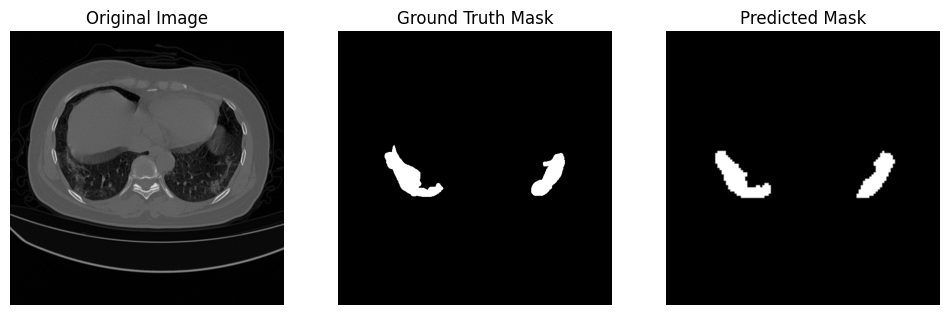

Dice Coefficient: 0.9019


In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Custom Dice Coefficient function
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Load models
model_path_1 = "/kaggle/working/segmentation_model.h5"
model_path_2 = "/kaggle/working/best_model.keras"

if os.path.exists(model_path_1):
    model = load_model(model_path_1, custom_objects={'dice_coefficient': dice_coefficient}, compile=False)
    print("Loaded segmentation_model.h5")
elif os.path.exists(model_path_2):
    model = load_model(model_path_2, custom_objects={'dice_coefficient': dice_coefficient}, compile=False)
    print("Loaded best_model.keras")
else:
    raise FileNotFoundError("No model found at the specified paths!")

# Function to preprocess image
def preprocess_image(image_path, img_size=(128, 128)):
    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, img_size)  # Resize to model input size
    image = image / 255.0  # Normalize
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to preprocess mask
def preprocess_mask(mask_path, img_size=(128, 128)):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale mask
    mask = cv2.resize(mask, img_size)  # Resize
    mask = mask / 255.0  # Normalize
    return np.expand_dims(mask, axis=(0, -1))  # Add batch & channel dimension

# Prediction function with Dice Score
def predict_and_display(image_path, mask_path=None):
    image = preprocess_image(image_path)  # Preprocess image
    pred_mask = model.predict(image)[0]  # Get prediction
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Apply threshold

    # Dice Score Calculation
    dice_score = None
    if mask_path:
        true_mask = preprocess_mask(mask_path)
        dice_score = tf.keras.backend.eval(dice_coefficient(true_mask, pred_mask))

    # Display results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    if mask_path:
        plt.subplot(1, 3, 2)
        ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(ground_truth_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

    # Print Dice Score
    if dice_score is not None:
        print(f"Dice Coefficient: {dice_score:.4f}")

# Example usage
image_path = "/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames/Jun_coronacases_case10_107.png"  # Replace with actual image path
mask_path = "/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks/Jun_coronacases_case10_107.png"  # Replace with actual mask path (optional)

predict_and_display(image_path, mask_path)


Loaded segmentation_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


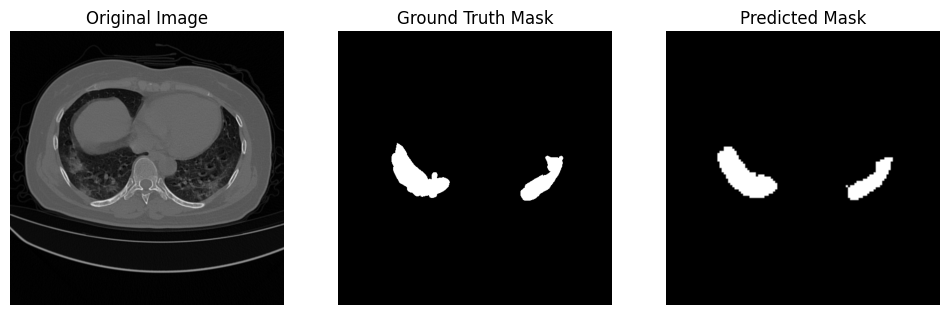

Dice Coefficient: 0.9156


In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Custom Dice Coefficient function
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Load models
model_path_1 = "/kaggle/working/segmentation_model.h5"
model_path_2 = "/kaggle/working/best_model.keras"

if os.path.exists(model_path_1):
    model = load_model(model_path_1, custom_objects={'dice_coefficient': dice_coefficient}, compile=False)
    print("Loaded segmentation_model.h5")
elif os.path.exists(model_path_2):
    model = load_model(model_path_2, custom_objects={'dice_coefficient': dice_coefficient}, compile=False)
    print("Loaded best_model.keras")
else:
    raise FileNotFoundError("No model found at the specified paths!")

# Function to preprocess image
def preprocess_image(image_path, img_size=(128, 128)):
    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, img_size)  # Resize to model input size
    image = image / 255.0  # Normalize
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to preprocess mask
def preprocess_mask(mask_path, img_size=(128, 128)):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale mask
    mask = cv2.resize(mask, img_size)  # Resize
    mask = mask / 255.0  # Normalize
    return np.expand_dims(mask, axis=(0, -1))  # Add batch & channel dimension

# Prediction function with Dice Score
def predict_and_display(image_path, mask_path=None):
    image = preprocess_image(image_path)  # Preprocess image
    pred_mask = model.predict(image)[0]  # Get prediction
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Apply threshold

    # Dice Score Calculation
    dice_score = None
    if mask_path:
        true_mask = preprocess_mask(mask_path)
        dice_score = tf.keras.backend.eval(dice_coefficient(true_mask, pred_mask))

    # Display results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    if mask_path:
        plt.subplot(1, 3, 2)
        ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(ground_truth_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

    # Print Dice Score
    if dice_score is not None:
        print(f"Dice Coefficient: {dice_score:.4f}")

# Example usage
image_path = "/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames/Jun_coronacases_case10_123.png"  # Replace with actual image path
mask_path = "/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks/Jun_coronacases_case10_123.png"  # Replace with actual mask path (optional)

predict_and_display(image_path, mask_path)


Loaded segmentation_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


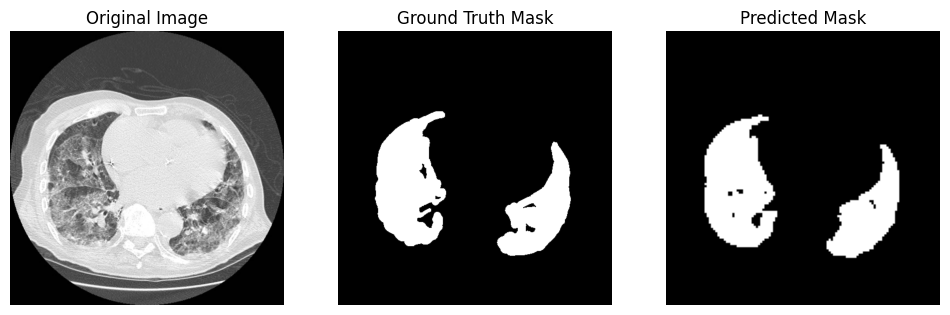

Dice Coefficient: 0.9356


In [2]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Custom Dice Coefficient function
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Load models
model_path_1 = "/content/segmentation_model.h5"
model_path_2 = "/content/best_model.keras"

if os.path.exists(model_path_1):
    model = load_model(model_path_1, custom_objects={'dice_coefficient': dice_coefficient}, compile=False)
    print("Loaded segmentation_model.h5")
elif os.path.exists(model_path_2):
    model = load_model(model_path_2, custom_objects={'dice_coefficient': dice_coefficient}, compile=False)
    print("Loaded best_model.keras")
else:
    raise FileNotFoundError("No model found at the specified paths!")

# Function to preprocess image
def preprocess_image(image_path, img_size=(128, 128)):
    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, img_size)  # Resize to model input size
    image = image / 255.0  # Normalize
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to preprocess mask
def preprocess_mask(mask_path, img_size=(128, 128)):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale mask
    mask = cv2.resize(mask, img_size)  # Resize
    mask = mask / 255.0  # Normalize
    return np.expand_dims(mask, axis=(0, -1))  # Add batch & channel dimension

# Prediction function with Dice Score
def predict_and_display(image_path, mask_path=None):
    image = preprocess_image(image_path)  # Preprocess image
    pred_mask = model.predict(image)[0]  # Get prediction
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Apply threshold

    # Dice Score Calculation
    dice_score = None
    if mask_path:
        true_mask = preprocess_mask(mask_path)
        dice_score = tf.keras.backend.eval(dice_coefficient(true_mask, pred_mask))

    # Display results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    if mask_path:
        plt.subplot(1, 3, 2)
        ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(ground_truth_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

    # Print Dice Score
    if dice_score is not None:
        print(f"Dice Coefficient: {dice_score:.4f}")

# Example usage
image_path = "/content/bjorke_1.png"  # Replace with actual image path
mask_path = "/content/bjorkem_1.png"  # Replace with actual mask path (optional)

predict_and_display(image_path, mask_path)


Loaded segmentation_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


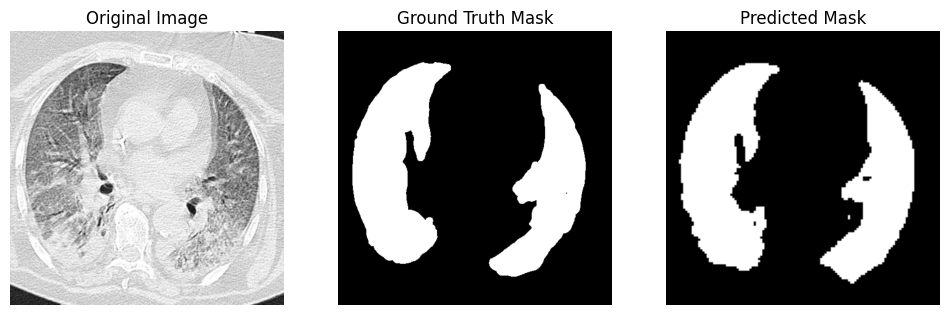

Dice Coefficient: 0.9282


In [6]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Custom Dice Coefficient function
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Load models
model_path_1 = "/content/segmentation_model.h5"
model_path_2 = "/content/best_model.keras"

if os.path.exists(model_path_1):
    model = load_model(model_path_1, custom_objects={'dice_coefficient': dice_coefficient}, compile=False)
    print("Loaded segmentation_model.h5")
elif os.path.exists(model_path_2):
    model = load_model(model_path_2, custom_objects={'dice_coefficient': dice_coefficient}, compile=False)
    print("Loaded best_model.keras")
else:
    raise FileNotFoundError("No model found at the specified paths!")

# Function to preprocess image
def preprocess_image(image_path, img_size=(128, 128)):
    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, img_size)  # Resize to model input size
    image = image / 255.0  # Normalize
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to preprocess mask
def preprocess_mask(mask_path, img_size=(128, 128)):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale mask
    mask = cv2.resize(mask, img_size)  # Resize
    mask = mask / 255.0  # Normalize
    return np.expand_dims(mask, axis=(0, -1))  # Add batch & channel dimension

# Prediction function with Dice Score
def predict_and_display(image_path, mask_path=None):
    image = preprocess_image(image_path)  # Preprocess image
    pred_mask = model.predict(image)[0]  # Get prediction
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Apply threshold

    # Dice Score Calculation
    dice_score = None
    if mask_path:
        true_mask = preprocess_mask(mask_path)
        dice_score = tf.keras.backend.eval(dice_coefficient(true_mask, pred_mask))

    # Display results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    if mask_path:
        plt.subplot(1, 3, 2)
        ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(ground_truth_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

    # Print Dice Score
    if dice_score is not None:
        print(f"Dice Coefficient: {dice_score:.4f}")

# Example usage
image_path = "/content/bjorke_8.png"  # Replace with actual image path
mask_path = "/content/bjorke_8m.png"  # Replace with actual mask path (optional)

predict_and_display(image_path, mask_path)


Loaded segmentation_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


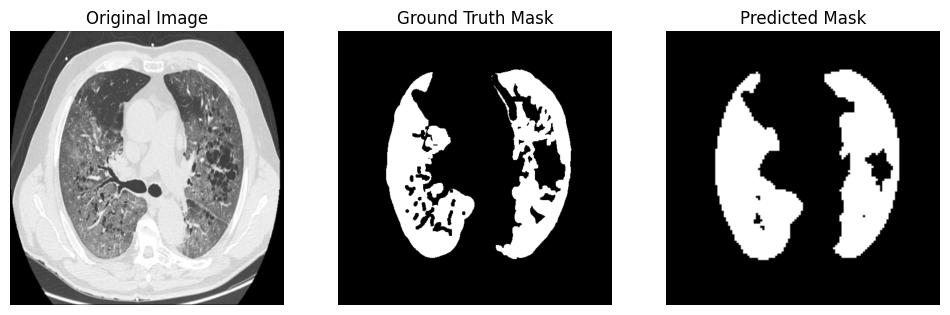

Dice Coefficient: 0.8787


In [9]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Custom Dice Coefficient function
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Load models
model_path_1 = "/content/segmentation_model.h5"
model_path_2 = "/content/best_model.keras"

if os.path.exists(model_path_1):
    model = load_model(model_path_1, custom_objects={'dice_coefficient': dice_coefficient}, compile=False)
    print("Loaded segmentation_model.h5")
elif os.path.exists(model_path_2):
    model = load_model(model_path_2, custom_objects={'dice_coefficient': dice_coefficient}, compile=False)
    print("Loaded best_model.keras")
else:
    raise FileNotFoundError("No model found at the specified paths!")

# Function to preprocess image
def preprocess_image(image_path, img_size=(128, 128)):
    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, img_size)  # Resize to model input size
    image = image / 255.0  # Normalize
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to preprocess mask
def preprocess_mask(mask_path, img_size=(128, 128)):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale mask
    mask = cv2.resize(mask, img_size)  # Resize
    mask = mask / 255.0  # Normalize
    return np.expand_dims(mask, axis=(0, -1))  # Add batch & channel dimension

# Prediction function with Dice Score
def predict_and_display(image_path, mask_path=None):
    image = preprocess_image(image_path)  # Preprocess image
    pred_mask = model.predict(image)[0]  # Get prediction
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Apply threshold

    # Dice Score Calculation
    dice_score = None
    if mask_path:
        true_mask = preprocess_mask(mask_path)
        dice_score = tf.keras.backend.eval(dice_coefficient(true_mask, pred_mask))

    # Display results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    if mask_path:
        plt.subplot(1, 3, 2)
        ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(ground_truth_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

    # Print Dice Score
    if dice_score is not None:
        print(f"Dice Coefficient: {dice_score:.4f}")

# Example usage
image_path = "/content/bjorke_30.png"  # Replace with actual image path
mask_path = "/content/bjorke_30m.png"  # Replace with actual mask path (optional)

predict_and_display(image_path, mask_path)
